<a href="https://colab.research.google.com/github/rdemarqui/financial_distress_prediction/blob/main/Financial_distress_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Distress Prediction

Source: https://www.kaggle.com/competitions/GiveMeSomeCredit/

In [1]:
!pip install -q scikit-optimize
!pip install -q shap

In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn import metrics
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
import shap

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Openning Files

In [4]:
# Getting current working directory
current_dir = os.getcwd()

In [5]:
# Downloading file
!wget -q https://github.com/rdemarqui/financial_distress_prediction/raw/main/datasets/GiveMeSomeCredit.zip

In [6]:
# Opening datasets
zf = zipfile.ZipFile(os.path.join(current_dir, 'GiveMeSomeCredit.zip'))
df_train = pd.read_csv(zf.open('cs-training.csv'), index_col=0, low_memory=False)
df_test = pd.read_csv(zf.open('cs-test.csv'), index_col=0, low_memory=False)

## Exploratory Data Analysis (EDA)

In [7]:
# Checking null values and data types
df_train.shape

(150000, 11)

In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


* Dataset has only numeric features. 
* Null values on *MonthlyIncome* and *NumberOfDependents*
* *Age* has some values filled with 0.

Unfortunately few estimators can natively handle missing data. Due to this, we'll fill null values with median, since some features have outliers.

In [9]:
df_train_final = df_train.copy()

fill_MonthlyIncome = df_train_final['MonthlyIncome'].median()
fill_NumberOfDependents = df_train_final['NumberOfDependents'].median()

df_train_final['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
df_train_final['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

In [10]:
# Splitting data
X_train = df_train_final.drop(columns=['SeriousDlqin2yrs'])
y_train = df_train_final['SeriousDlqin2yrs']

##Training

We're going to use cross validation to train all models. In this case we will split in 1/5, where 80% for training and 20% for validation.

In [37]:
def cross_validation(model=None, X=None, y=None, n_splits=5, shuffle=True, oversampling=False, random_state=42):
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
  scores = []

  for idx, (idx_train, idx_validation) in enumerate(kfold.split(X, y)):
    X_train_split = X.iloc[idx_train, :]
    y_train_split = y.iloc[idx_train]

    if oversampling:
      sm = SMOTE(random_state=random_state)
      X_train_split, y_train_split = sm.fit_resample(X_train_split, y_train_split)

    model.fit(X_train_split, y_train_split)

    X_val_split = X.iloc[idx_validation, :]
    y_val_split = y.iloc[idx_validation]

    val_predict = model.predict_proba(X_val_split)[:, 1]

    split_score = round(metrics.roc_auc_score(y_val_split, val_predict), 6)
    scores.append(split_score)

  return scores

In [38]:
def train_models(all_models, oversampling=None):
  all_results = {}
  for model in all_models:
    model_name = str(model).split('(')[0]
    print(f'Training: {model_name}')
    result = cross_validation(model, X_train, y_train, oversampling=oversampling)
    all_results[model_name] = result

  df_results = (pd.DataFrame.from_dict(all_results).T)
  df_results['mean'] = df_results.mean(axis=1)
  df_results = df_results.sort_values(by=['mean'], ascending=False)
  return df_results

### Choosing Best Model

First, we'll try many algorithms to see which one does better.

In [39]:
# Listing all models
mRandState = {'random_state':42}
all_models = [
    AdaBoostClassifier(**mRandState), HistGradientBoostingClassifier(**mRandState),
    ExtraTreesClassifier(**mRandState), RandomForestClassifier(**mRandState),
    LogisticRegression(max_iter=3000, **mRandState), GaussianNB(),
    BernoulliNB(), MultinomialNB(), DecisionTreeClassifier(**mRandState), 
    XGBClassifier(**mRandState), LGBMClassifier(**mRandState)
    ]

#### Oversampling

In [ ]:
results_oversampling = train_models(all_models, oversampling=True)

Training: AdaBoostClassifier
Training: HistGradientBoostingClassifier
Training: ExtraTreesClassifier


In [ ]:
# Checking all results using oversampling
results_oversampling

#### Unbalanced

In [ ]:
results_stratified = train_models(all_models, oversampling=False)

In [ ]:
# Checking all results using oversampling
results_stratified

#### Comparing Results

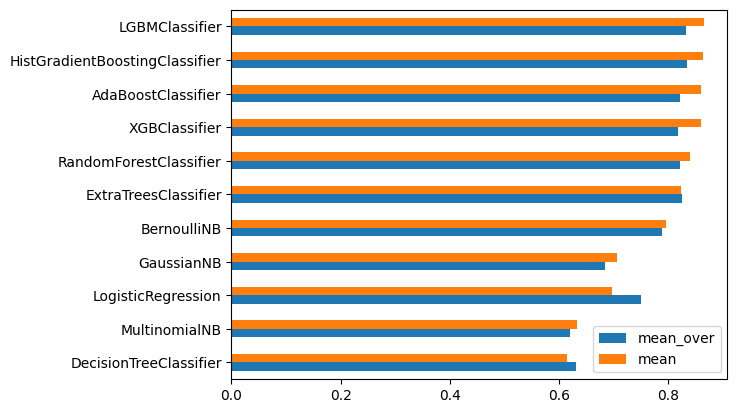

In [18]:
df_compare = pd.DataFrame(results_oversampling['mean']).rename(columns={'mean':'mean_over'})
df_compare = df_compare.join(results_stratified['mean'])
df_compare = df_compare.sort_values(by=['mean'], ascending=True)
ax = df_compare.plot.barh()

In [19]:
df_compare = df_compare.sort_values(by=['mean'], ascending=False)
df_compare['difference'] = df_compare['mean_over'] - df_compare['mean']
df_compare

,mean_over,mean,difference
LGBMClassifier,0.831442,0.864984,-0.033541
HistGradientBoostingClassifier,0.833419,0.864214,-0.030796
AdaBoostClassifier,0.821372,0.859480,-0.038108
XGBClassifier,0.817795,0.858935,-0.041140
RandomForestClassifier,0.821004,0.839117,-0.018113
ExtraTreesClassifier,0.824655,0.823654,0.001001
BernoulliNB,0.788732,0.795880,-0.007148
GaussianNB,0.684538,0.705393,-0.020855
LogisticRegression,0.749066,0.696028,0.053038
MultinomialNB,0.620249,0.633364,-0.013116


As we can see, oversampling made more harm than good in most of our models.

The best result was achieved by **HistGradientBoostingClassifier**. Let's fine tuning it's parameters then.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html

### Hyperparameter Tuning

Since we're no longer using oversampling, we can perform optimization directly with cross_validation.

In [20]:
def param_opt(model, params, X, y, opt_method='', n_iter=10, score='roc_auc', n_splits=5, shuffle=False, n_jobs=4): 
  """
  Function to optimize algorithm hyperparameters
     If opt_method = 'Grid' then all combinations of hyperparameters will be tested for GridSearchCV
     If opt_method = 'Random', 10 hyperparameters will be tested randomly
     If opt_method = 'Bayes', 10 hyperparameters will be randomly tested and then Bayesian optimization will be performed (default)
  """

  # Defining kfold
  if shuffle == False:
    val_random = None
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=val_random)

  if opt_method.upper() == 'GRID':
    grid = GridSearchCV(model, params, cv=kfold, n_jobs=n_jobs, scoring=score)
  elif opt_method.upper() == 'RANDOM':
    grid = RandomizedSearchCV(model, params, cv=kfold, n_iter=n_iter, n_jobs=n_jobs, random_state=val_random, scoring=score)
  elif opt_method.upper() == 'BAYES':
    # Optimizers['GP', 'RF', 'ET', 'GBRT']: https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer
    grid = BayesSearchCV(model, params, cv=kfold, n_iter=n_iter, n_jobs=n_jobs, optimizer_kwargs={'base_estimator':'GP'}, random_state=val_random, scoring=score)
  
  # Training model
  grid.fit(X, y)

  # Best hiperparameters
  best_params = dict(grid.best_params_)
  print("Best params:", best_params)
  
  # Best score
  best_score = grid.best_score_
  print(f"Best score({score}): {best_score:.5}\n")

  return best_params

In [21]:
params = {}

params['learning_rate'] = [0.001, 0.01, 0.1, 0.3, 0.5]   # (default=0.3)
params['max_iter'] = [50, 100, 150, 200, 300]    # (default=100)
params['max_leaf_nodes'] = [10, 20, 31, 50]    # (default=31)
params['max_depth'] = [None, 3, 5, 6, 7]    # (default=None)
params['min_samples_leaf'] = [10, 20, 30, 50]    # (default=20)
params['l2_regularization'] = [0, 0.001, 0.01, 0.1, 0.3, 0.5, 1]    # (default=0)
params['random_state'] = [42]

n_comb = np.prod([len(params[key]) for key in params.keys()])
print(f'Possible matches: {n_comb}\n')

Possible matches: 14000



In [22]:
# Tuning hyperparameters
best_param = param_opt(model=HistGradientBoostingClassifier(), params=params,
                       X=X_train, y=y_train, opt_method='bayes',
                       score='roc_auc', n_iter=50, n_splits=5)

KeyboardInterrupt: ignored

Best params: {'min_samples_leaf': 10, 'max_leaf_nodes': 20, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1, 'l2_regularization': 0.01}
Best score(roc_auc): 0.86531

In [ ]:
best_param

We have a tinny improvement compared with vanilla model, but it's better than nothing.

## Testing

As we're working with a kaggle challenge dataset, the test dataset don't have  labels. To verify the performance achieved by the model, we'll have to upload the prediction directly to the platform.

In [ ]:
# Filling null values with median of df_train
X_test = df_test.drop(columns=['SeriousDlqin2yrs'])
X_test['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
X_test['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

In [ ]:
X_test.head()

In [ ]:
final_model = HistGradientBoostingClassifier(**best_param).fit(X_train, y_train)

In [ ]:
predicted_values = pd.DataFrame(final_model.predict_proba(X_test)[:, 1]).reset_index()
predicted_values.rename(columns={'index':'Id', 0:'Probability'}, inplace=True)
predicted_values['Id'] = predicted_values['Id'] + 1
predicted_values['Id'] = predicted_values['Id'].astype(int)
predicted_values

In [ ]:
# Exporting results
predicted_values.to_csv('predicted_values.csv', index=False, sep=',', decimal='.')

Kaggle returned scores **~0.867** for private score and **~0.861** for public score. It's a good result, considering that the winer got **0.86955**.

Maybe we could improve that creating a stack with the top best performers, but if we would do that we will lost the ability of explainability, seen in next topic.

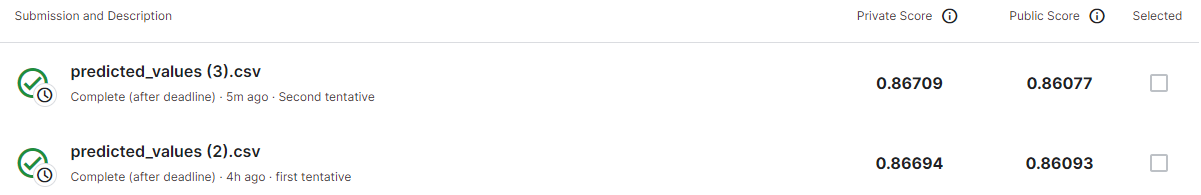

## Explaining

An important part of analysis is to understand which features the model considered most important for decision making. For this challenge, we are going to use SHAP.

In [ ]:
def shapley_feature_ranking(shap_values, X, top=10):
  """
  Extract global values from SHAP
  """
  feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
  return pd.DataFrame(
      {
          "features": [X.columns[i] for i in feature_order][::-1],
          "importance": [
              np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
          ][::-1],
      }
  ).head(top)

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

In [ ]:
# Feature Importance
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Feature Importance', fontsize=20)
plt.show()

In [ ]:
top_features = shapley_feature_ranking(shap_values, X_test, top=X_test.shape[1])
feat_name =  pd.merge(pd.DataFrame({'features':X_test.columns}), top_features, how="left", on=["features"])

feat_val = [
             col + " [" + str(round(feat_name.iloc[i]['importance'], 3)) + "]"
             for i, col in enumerate(feat_name['features'])
             ]

shap.summary_plot(shap_values, X_test, feature_names=feat_val, show=False)
plt.show()